# VERSION 1.2

#### I'm going to make a fake news predictor, and you are going to join me on my journey trying to solve one of humanities most difficult challenges. 
#### So, fake news has been around since before 'news' became a thing. But I want to tackle this issue, and try to contribute to saving democracy while preserving our rights to freedom of speech!

Now let's load the packages that we're going to need throughout our project.

In [2]:
# Data importation & manipulation
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

# Modelling & Prediction 
import nltk as nltk
import re
import math
import numpy as np
from datetime import datetime

# Text Preprocessing
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from sklearn.preprocessing import StandardScaler

# Splitting
from sklearn.model_selection import train_test_split, cross_val_score

# SVM
from sklearn.svm import SVC
from sklearn import svm

# KNN
from sklearn.neighbors import KNeighborsClassifier
from math import sqrt
from sklearn import neighbors

# Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# Linear model
from sklearn.linear_model import PassiveAggressiveClassifier

# Deep Learning LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

sns.set(color_codes = True)
%matplotlib inline

#### Explore fake news dataset

We will first load the fake news dataset then run info function to have a look at the dataset and its content. You can see that there's 23481 rows and 5 columns in total. All columns has 'object' as type

In [3]:
fakeNewsData = pd.read_csv('data/Fake.csv', parse_dates=['date'])
fakeNewsData['label'] =  'fake'
fakeNewsData.info()
fakeNewsData.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
 4   label    23481 non-null  object
dtypes: object(5)
memory usage: 917.4+ KB


,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",fake


#### Convert date column to datetime type

Hhhmmm, the date column looks kind of funny. Let's have a closer look at it. First, I tried to convert date column to date and ran into an issue i didnt noticed before. 

###### Below is the error: ParserError: Unknown string format: https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/

There's a link in the date column. HOW? That we don't know. I did the following to select only the rows that are actually date values.
So, i tried to convert the date column to date with an extra parameter this time, I used error is coerce. 

What this does is it parse the string to NaT. Doing this we will convert the string dates to actual date types and strings that are not date values will be set as NaT. This will help us to filter/select only the date values to take into our dataset.

ref: https://datatofish.com/create-nan-values-pandas-dataframe/
ref: https://datatofish.com/convert-string-to-float-dataframe/
ref: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html

In [4]:
fakeNewsData['date'] = pd.to_datetime(fakeNewsData['date'], errors='coerce')

Here you see the rows that are not of date type. 10 rows.

In [5]:
fakeNewsData.date[fakeNewsData.date.isnull()]

9358    NaT
15507   NaT
15508   NaT
15839   NaT
15840   NaT
17432   NaT
17433   NaT
18933   NaT
21869   NaT
21870   NaT
Name: date, dtype: datetime64[ns]

Below we will selct only the rows that are of dae type into our dataset.

In [6]:
fakeNewsData = fakeNewsData[fakeNewsData['date'].notna()]

You can see in the table and the list above that the date column has some issues compared to the true news date column. There's a link in the date column... huh? We don't want that. So, lets remove the links from the date column and convert the column to datetime.

In [7]:
# fakeNewsData = fakeNewsData[fakeNewsData.date.str.contains("Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec")] # get only string that contains the months
# fakeNewsData['date'] = pd.to_datetime(fakeNewsData['date'], format='%Y-%m-%d') # convert column to datetime

fakeNewsData.info()
fakeNewsData.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23471 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   title    23471 non-null  object        
 1   text     23471 non-null  object        
 2   subject  23471 non-null  object        
 3   date     23471 non-null  datetime64[ns]
 4   label    23471 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 1.1+ MB


,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,fake


Now you can see that date columns is datetime type.

#### Explore the true dataset

Load the true news dataset then run info function to have a look at the dataset. 
You can see that there's 21417  rows and 5 columns in total. All columns has 'object' as type, except for the date column which is of datetime type

In [8]:
trueNewsData = pd.read_csv('data/True.csv', parse_dates=['date'])
trueNewsData['label'] = 'true'
trueNewsData.info()
trueNewsData.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   title    21417 non-null  object        
 1   text     21417 non-null  object        
 2   subject  21417 non-null  object        
 3   date     21417 non-null  datetime64[ns]
 4   label    21417 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 836.7+ KB


,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,true
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,true
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,true
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,true
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,true


#### Convert date column to datetime type

We can see that the date column in already converted to date type. But still, let's make sure there's no mistakes like the fake news dataset.

Let's run the same steps we did with the fake news dataset. Convert column to date type and add parameter error as coerce.

ref: https://datatofish.com/create-nan-values-pandas-dataframe/
ref: https://datatofish.com/convert-string-to-float-dataframe/
ref: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html

In [9]:
trueNewsData['date'] = pd.to_datetime(trueNewsData['date'], errors='coerce')

Let's return the NaT values.

Fortunately, there are no wrong values in the true news date column.

In [10]:
trueNewsData.date[trueNewsData.date.isnull()]

Series([], Name: date, dtype: datetime64[ns])

#### Combine datasets

Now let's combined the datasets! And return the shape to ssee how many rows and columns are available.

ref: https://realpython.com/pandas-merge-join-and-concat/
ref: https://pythonprogramming.net/combining-datasets-python3-pandas-data-analysis/
ref: https://www.geeksforgeeks.org/how-to-combine-two-dataframe-in-python-pandas/
ref: https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
ref: https://khalidgharib.medium.com/combining-data-python-pandas-34fa73501c8c

In [11]:
# Concantenate the datasets, why? 
# Both datasets are very similar in terms of the columns. 
# Since their identical, we can't make a join on a column.
newsData = pd.concat([fakeNewsData, trueNewsData], ignore_index=True) # fakeNewsData.join(trueNewsData, how='outer', lsuffix="_left", rsuffix="_right")

# combine title and text to create a new column, news.
newsData['news'] = newsData['title'] + newsData['text']

# drop the title and text columns since they are not needed anymore.
newsData = newsData.drop(['title', 'text', 'date'], axis=1)

# # re-arrange the combined dataset columns
newsData = newsData.reindex(columns=['news', 'subject', 'date', 'label'])

Let's look at the shape of our combined data. You will notice that there's over 44k rows and 4 columns.

In [12]:
newsData.shape

(44888, 4)

#### Label distribution

Lets have a look at how the labels are distributed. You can see that fake news is more occurent than the true news. More fake articles than true/real articles. However, they are still fairly balanced I would say. Both are above the 20K. You agree? Of course you do.

C:\Users\Gebruiker\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

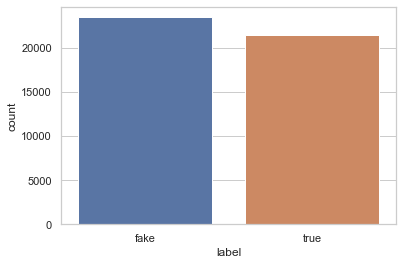

In [13]:
target_label = newsData['label']
sns.set_style('whitegrid')
sns.countplot(target_label)

#### Plot subjects by label

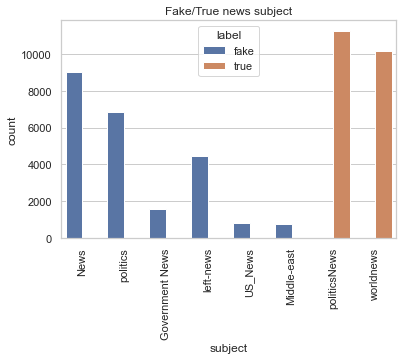

In [14]:
_ = sns.countplot(x ='subject', hue= 'label', data = newsData)
plt.xticks(rotation=90)
plt.title('Fake/True news subject')
plt.show()

Lets have a look at the subjects. You can see that there's some ambigous columns. For exmple, for the fake dataset "government news" and "politics" basically has the same meaning and what about "news" what type of news is it? It could be anything from my point of view.
Furthermore, "politics news" and "world news" has rows of more than 10k each. 

#### Cleaning news data in the news column

There's a lot of useless words in the dataset, and that's not good for our algorithm when it's time to predict. What should we do? Let's clean it up! We'll do that in a few steps. First we will remove all punctuation from the news column then we will remove the stop words. Stop words are words such as the, a, an, in, and more. So, this way only the important words will be used by our algorithm to predict.

--- stop words ---
ref: https://studymachinelearning.com/nlp-stop-words/
ref: https://thatascience.com/learn-machine-learning/stop-words/

In [15]:
stop_words = stopwords.words('english')

In [16]:
def clean_data(word):
#     word = str(word).lower() # set all to lowercase
    word = re.sub(r'[^\w\s]', '', word) # remove punctuation
    return word

In [17]:
# use lambda function here to apply the clean_data() to the news column
# use axis 0 to apply function to each column and axis 1 to apply function to each row.
newsData.news = newsData.news.apply(lambda x:clean_data(x))

After calling the clean_data(), let's have a look at the dataframe. Immediately, you can see the clear difference (btw the difference is in the news column). There's no commas, or dots, or brackets, none of that. ALL GONE!

In [18]:
newsData.head()

,news,subject,date,label
0,Donald Trump Sends Out Embarrassing New Years...,News,NaN,fake
1,Drunk Bragging Trump Staffer Started Russian ...,News,NaN,fake
2,Sheriff David Clarke Becomes An Internet Joke...,News,NaN,fake
3,Trump Is So Obsessed He Even Has Obamas Name ...,News,NaN,fake
4,Pope Francis Just Called Out Donald Trump Dur...,News,NaN,fake


In the next step we're going to remove stop words. To have a more clearer visual of what happened, let's return the length of characters in the first row.

#### Remove stop words

Above you can see the length is 2849. Now let's remove the stop words then have a look at the length again.

In [19]:
len(newsData.news.values[0])

2849

In [20]:
newsData.news = newsData.news.apply(lambda x: ' '.join([w for w in x.split() if w not in stop_words]))

After removing the stop words, you can see a difference in the length of characters in the first row. Removing stop words makes it easier for our algorithm to predict

In [21]:
len(newsData.news.values[0])

2107

Now that our news data looks better and ready for prediction, let's plot a word cloud to have a visualization of the most frequent words in news that's labeled as fake news. 

But this one might be a bit more advance. You're probably wondering why, that's a good question. The words we are going to plot in the word cloud are the 50 most common words in the fake news. This is done by using collections Counter. This class is very useful to count the frequency of elements in an iterable. It is a collection where elements are stored as dictionary keys and their counts are stored as dictionary values. 

#### Word cloud

Lets use counter on news labeled as fake news to return the most common 100 words.

ref: https://www.askpython.com/python/examples/word-cloud-using-python#:~:text=%20How%20to%20Create%20a%20Word%20Cloud%20using,cloud%20mask%20and%20set%20stop%20words%20More%20
ref: https://www.datacamp.com/community/tutorials/wordcloud-python

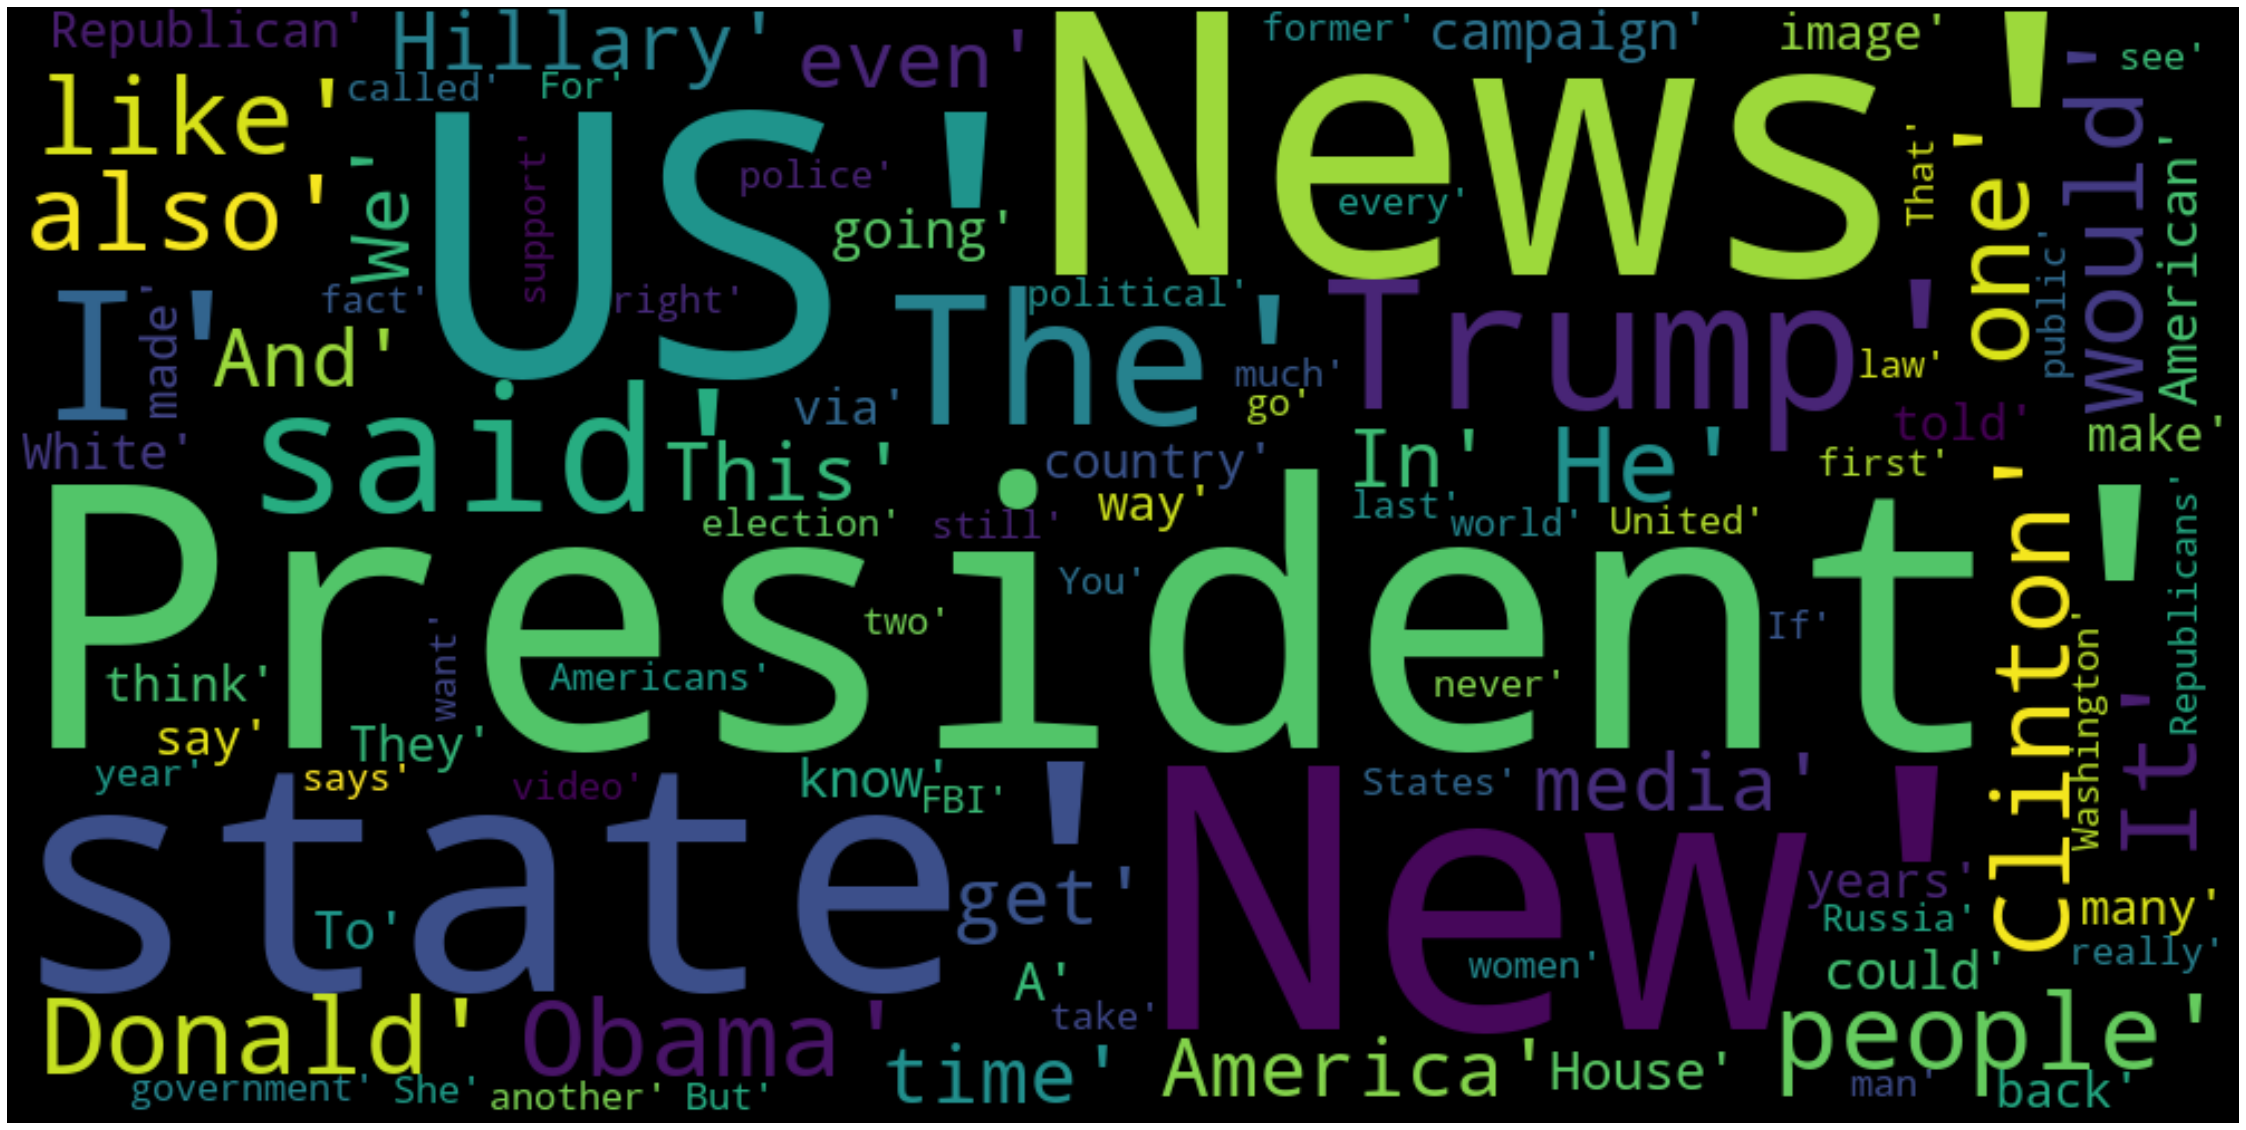

In [22]:
text = Counter(" ".join(newsData[newsData['label'] == 'fake']['news']).split()).most_common(100)
wordcloud = WordCloud(width=1000, height=500, background_color = 'black', stopwords = stop_words).generate(str(text))

fig, ax = plt.subplots(figsize=(40,40))
plt.imshow( wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

You can see that the most frequent words are US, Trump, President, State, Clinton and more. So, as i said in the project proposal the prediction will be biased and will not perform well with other types of news because it's being trained and tested on world news, and american news (regarding the 2016 election). 
However, as our we modify our algorithm and tune it, we can have it predict all types of news. But for now, let's use this dataset just to see how well it predicts fake news.

Lets use counter on news labeled as real/true news to return the most common 100 words.

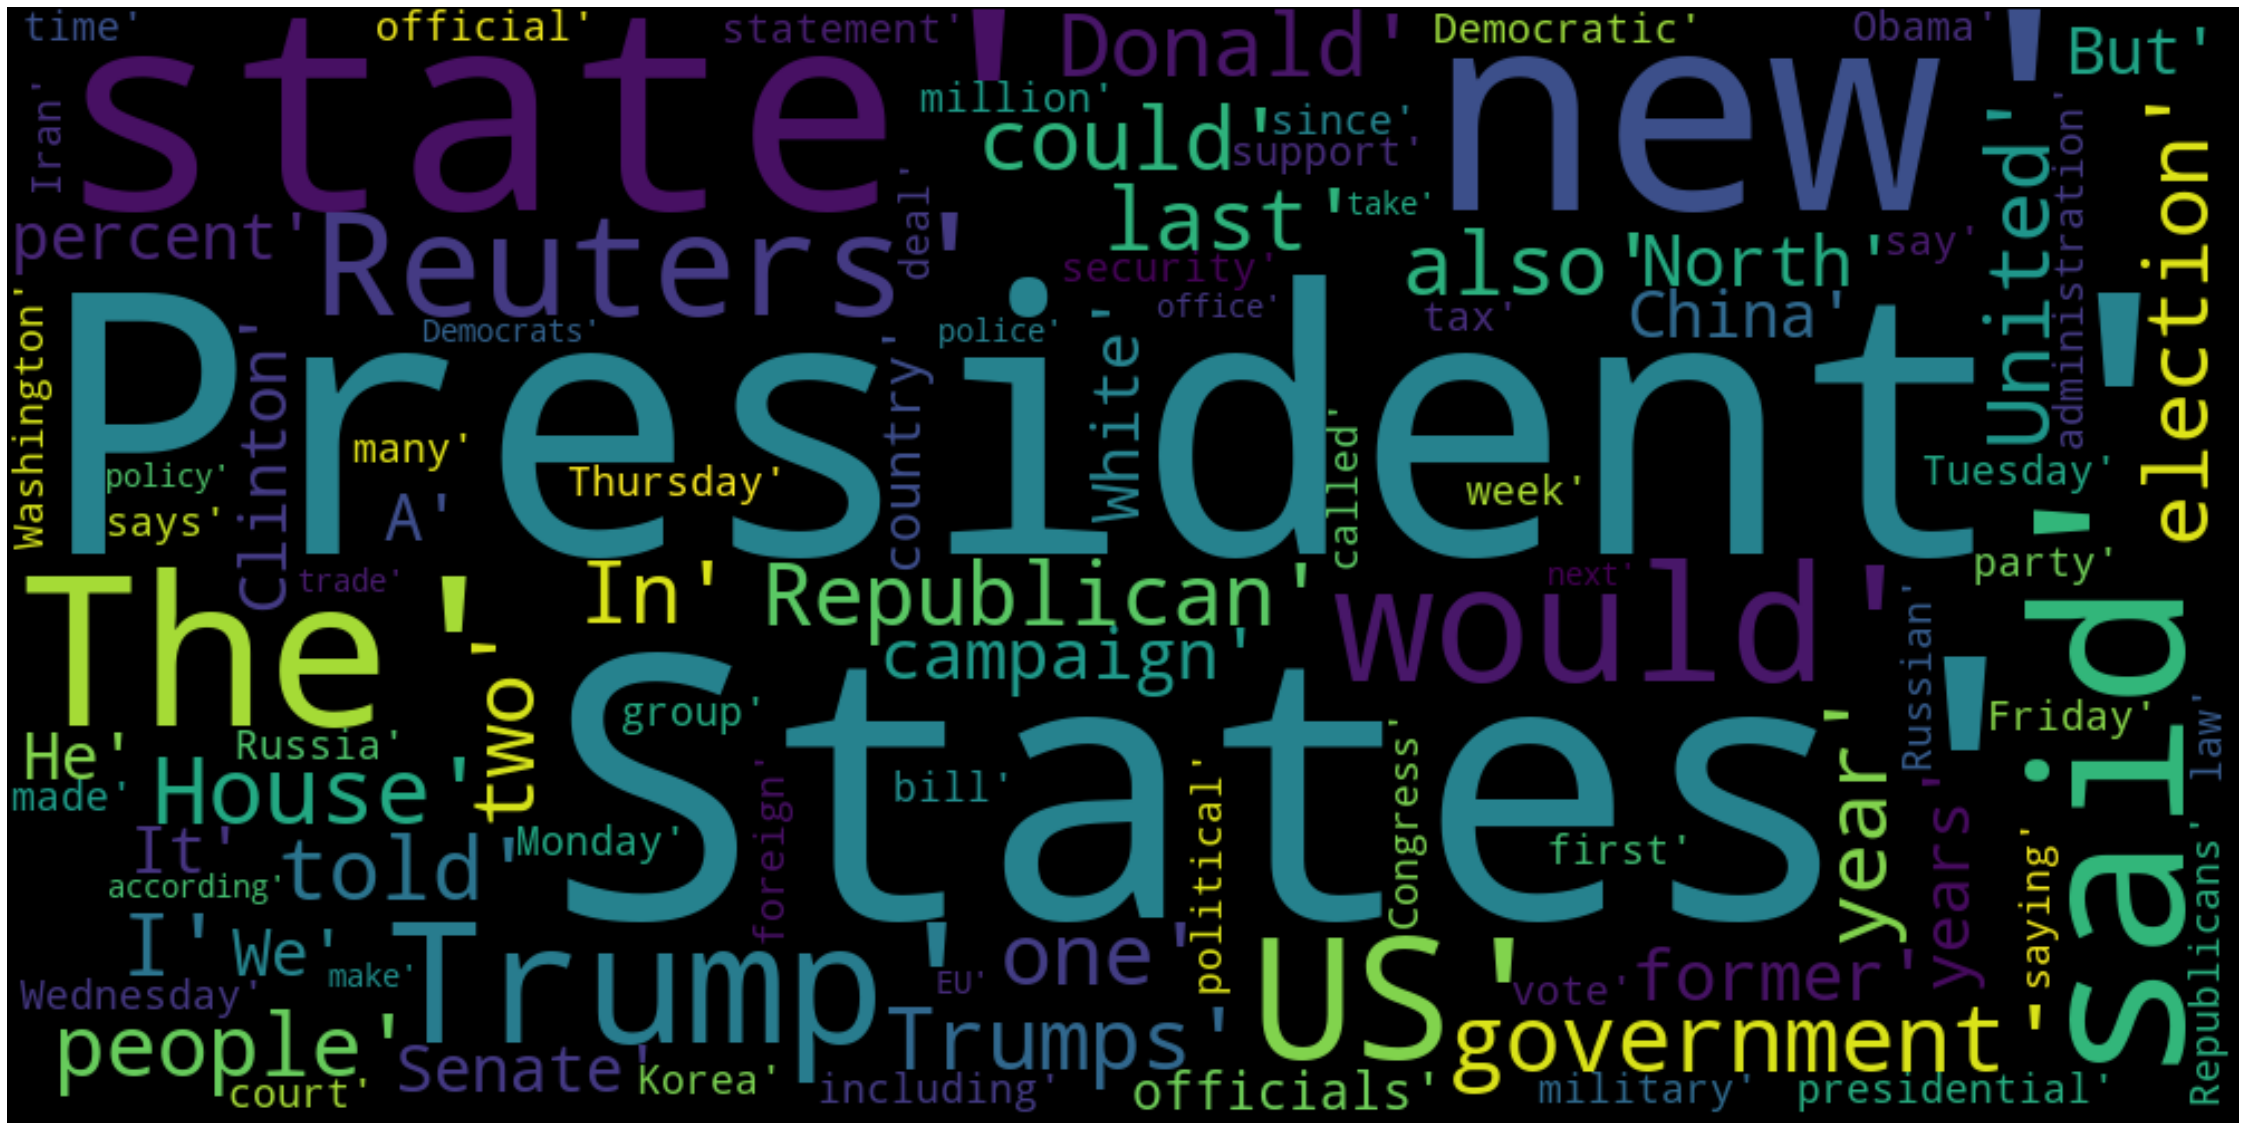

In [23]:
text = Counter(" ".join(newsData[newsData['label'] == 'true']['news']).split()).most_common(100)
wordcloud = WordCloud(width=1000, height=500, background_color = 'black', stopwords = stop_words).generate(str(text))

fig, ax = plt.subplots(figsize=(40,40))
plt.imshow( wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [24]:
newsData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44888 entries, 0 to 44887
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   news     44888 non-null  object 
 1   subject  44888 non-null  object 
 2   date     0 non-null      float64
 3   label    44888 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.4+ MB


In [25]:
y = newsData.label
X = newsData.news

In [26]:
X.shape

(44888,)

In [27]:
y.shape

(44888,)

#### Split training and testing sets

Now that all the boring stuff is done, let's get to work. In the next part i will show you how we're going to split our dataset into train and test sets!
We're going to use 30% of our data for testing set and stratify the labels (y).

ref: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)

After splitting the data, we can see that X has a shape of 31421 values and y with 13467 values.

In [29]:
X_train.shape

(35910,)

In [30]:
y_train.shape

(35910,)

#### Feature extraction using CountVectorizer

ref: https://investigate.ai/text-analysis/counting-words-with-scikit-learns-countvectorizer/
ref: https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568#:~:text=Linear%20Support%20Vector%20Machine%20is%20widely%20regarded,as%20one%20of%20the%20best%20text%20classification%20algorithms.

In [31]:
count_vectorizer = CountVectorizer()

In [32]:
# We fit and transform the training data
count_train = count_vectorizer.fit_transform(X_train)

In [33]:
# Return the shape of training data
count_train.shape

(35910, 224015)

In [34]:
# Then transform the testing data
count_test = count_vectorizer.transform(X_test)

In [35]:
# Return the shape of testing data
count_test.shape

(8978, 224015)

#### Feature extraction using TF-IDFVectorizer

In [36]:
tfidf_vectorizer = TfidfVectorizer() 

In [37]:
# We fit and transform the training data
tfidf_train = tfidf_vectorizer.fit_transform(X_train) 

In [38]:
# Return the shape of training data
tfidf_train.shape

(35910, 224015)

In [39]:
# Then transform the testing data
tfidf_test = tfidf_vectorizer.transform(X_test)

In [40]:
# Return the shape of testing data
tfidf_test.shape

(8978, 224015)

#### Text classification algorithms
ref: https://medium.com/text-classification-algorithms/text-classification-algorithms-a-survey-a215b7ab7e2d#:~:text=%20Text%20Classification%20Algorithms%3A%20A%20Survey%20%201,of%20Rocchio%20algorithm...%205%20Citations%3A.%20%20More%20

Method to plot confusion matrix for the different types of algotithms

In [41]:
def plot_confusion_matrix(confusion_matrix):
    labels = ['fake', 'true'] 
    fig = plt.figure() 

    ax = fig.add_subplot(111) 

    cax = ax.matshow(confusion_matrix) 

    plt.title('Confusion matrix of the classifier') 

    fig.colorbar(cax) 

    ax.set_xticklabels([''] + labels) 

    ax.set_yticklabels([''] + labels) 

    plt.xlabel('Predicted') 

    plt.ylabel('True') 

    plt.show()

#### Naive Bayes classification using count vectorizer.
ref: https://www.geeksforgeeks.org/naive-bayes-classifiers/#:~:text=%20Other%20popular%20Naive%20Bayes%20classifiers%20are%3A%20,features%20are%20independent%20booleans%20%28binary%20variables%29...%20More%20

In [86]:
# Instantiate a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

In [87]:
# Fit the classifier to the training data
nb_classifier.fit(count_train, y_train)

MultinomialNB()

In [88]:
# Create the predicted tags: pred
pred = nb_classifier.predict(count_test)

#### Metrics part 1

In [89]:
matrix = classification_report(y_test, pred, labels=['fake', 'true'])
print('Classification report : \n',matrix, )

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred)
print("Multinomial Naive Bayes model accuracy(in %):", score * 100, '\n')

# Calculate the confusion matrix: cm
tn_nb, fp_nb, fn_nb, tp_nb = metrics.confusion_matrix(y_test, pred, labels=['fake', 'true']).ravel()
print('True negative:', tn_nb , ' - ', 'False positive:', fp_nb, 
      ' - ', 'False negative:', fn_nb, ' - ', 'True positive:', tp_nb, '\n')

cm_nb = metrics.confusion_matrix(y_test, pred, labels=['fake', 'true'])
print(cm_nb)

Classification report : 
               precision    recall  f1-score   support

        fake       0.97      0.96      0.96      4694
        true       0.96      0.96      0.96      4284

    accuracy                           0.96      8978
   macro avg       0.96      0.96      0.96      8978
weighted avg       0.96      0.96      0.96      8978

Multinomial Naive Bayes model accuracy(in %): 96.33548674537758 

True negative: 4525  -  False positive: 169  -  False negative: 160  -  True positive: 4124 

[[4525  169]
 [ 160 4124]]


In [90]:
import pickle

In [91]:
with open('nb_countvec_pred', 'wb') as file:
    pickle.dump(nb_classifier, file)

Above you can see that the model gave us an accuracy score of 96.34%.
And there is 6796 true negatives and 6179 true positives.

Plot confusion matrix

<ipython-input-41-84b40dbd2607>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-41-84b40dbd2607>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


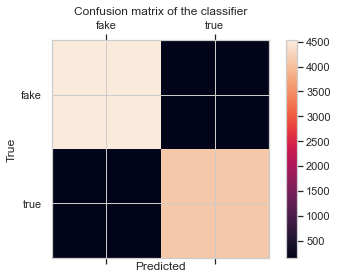

In [92]:
plot_confusion_matrix(cm_nb)

#### Cross validation metrics for the count vectorizer

In [93]:
scores = cross_val_score(nb_classifier, count_train, y_train, cv=5, scoring='accuracy')
print(scores)

[0.96505152 0.96184907 0.96435533 0.96491228 0.96157059]


#### Naive Bayes classification using TF-IDF vectorizer.

In [94]:
# Fit the classifier to the training data
nb_classifier.fit(tfidf_train, y_train)

MultinomialNB()

In [95]:
# Create the predicted tags: pred
tf_pred = nb_classifier.predict(tfidf_test)

In [96]:
matrix = classification_report(y_test, tf_pred, labels=['fake', 'true'])
print('Classification report : \n',matrix, )

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, tf_pred)
print("Multinomial Naive Bayes model accuracy(in %):", score * 100, '\n')

# Calculate the confusion matrix: cm
tn_nb, fp_nb, fn_nb, tp_nb = metrics.confusion_matrix(y_test, tf_pred, labels=['fake', 'true']).ravel()
print('True negative:', tn_nb , ' - ', 'False positive:', fp_nb, 
      ' - ', 'False negative:', fn_nb, ' - ', 'True positive:', tp_nb, '\n')

cm_nb_tf = metrics.confusion_matrix(y_test, tf_pred, labels=['fake', 'true'])
print(cm_nb_tf)

Classification report : 
               precision    recall  f1-score   support

        fake       0.95      0.95      0.95      4694
        true       0.95      0.94      0.95      4284

    accuracy                           0.95      8978
   macro avg       0.95      0.95      0.95      8978
weighted avg       0.95      0.95      0.95      8978

Multinomial Naive Bayes model accuracy(in %): 94.88750278458454 

True negative: 4479  -  False positive: 215  -  False negative: 244  -  True positive: 4040 

[[4479  215]
 [ 244 4040]]


In [97]:
with open('nb_tfidfvec_pred', 'wb') as file:
    pickle.dump(nb_classifier, file)

Plot confusion matrix

<ipython-input-41-84b40dbd2607>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-41-84b40dbd2607>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


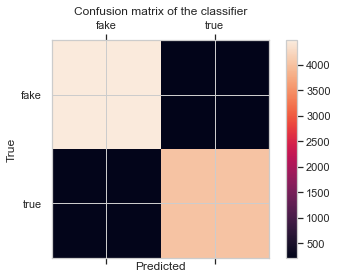

In [98]:
plot_confusion_matrix(cm_nb_tf)

#### Cross validation metrics for the TF-IDF vectorizer

In [99]:
scores = cross_val_score(nb_classifier, tfidf_train, y_train, cv=5, scoring='accuracy')
print(scores)

[0.95196324 0.94597605 0.95140629 0.95098858 0.94667224]


#### PassiveAgressive classification using TF-IDF vectorizer.

In [53]:
linear_clf = PassiveAggressiveClassifier(max_iter=50)

In [54]:
linear_clf.fit(tfidf_train, y_train)

PassiveAggressiveClassifier(max_iter=50)

In [55]:
linear_clf_pred = linear_clf.predict(tfidf_test)

In [56]:
matrix = classification_report(y_test, linear_clf_pred, labels=['fake', 'true'])
print('Classification report : \n',matrix, )

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, linear_clf_pred)
print("Multinomial Naive Bayes model accuracy(in %):", score * 100, '\n')

# Calculate the confusion matrix: cm
tn_nb, fp_nb, fn_nb, tp_nb = metrics.confusion_matrix(y_test, linear_clf_pred, labels=['fake', 'true']).ravel()
print('True negative:', tn_nb , ' - ', 'False positive:', fp_nb, 
      ' - ', 'False negative:', fn_nb, ' - ', 'True positive:', tp_nb, '\n')

cm_pac = metrics.confusion_matrix(y_test, linear_clf_pred, labels=['fake', 'true'])
print(cm_pac)


# score = metrics.accuracy_score(y_test, pred)
# print("accuracy:   %0.3f" % score)
# cm = metrics.confusion_matrix(y_test, pred, labels=['fake', 'true'])
# print(cm)

Classification report : 
               precision    recall  f1-score   support

        fake       1.00      1.00      1.00      4694
        true       1.00      0.99      1.00      4284

    accuracy                           1.00      8978
   macro avg       1.00      1.00      1.00      8978
weighted avg       1.00      1.00      1.00      8978

Multinomial Naive Bayes model accuracy(in %): 99.56560481176209 

True negative: 4678  -  False positive: 16  -  False negative: 23  -  True positive: 4261 

[[4678   16]
 [  23 4261]]


In [100]:
with open('linear_clf_tfidf_pred', 'wb') as file:
    pickle.dump(linear_clf, file)

Plot confusion matrix

<ipython-input-41-84b40dbd2607>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-41-84b40dbd2607>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


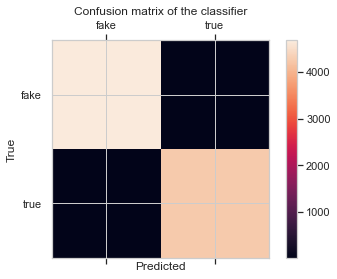

In [101]:
plot_confusion_matrix(cm_pac)

#### Cross validation metrics for the TF-IDF vectorizer

In [102]:
scores = cross_val_score(linear_clf, tfidf_train, y_train, cv=5, scoring='accuracy')
print(scores)

[0.99512671 0.99443052 0.9962406  0.99610136 0.99345586]


#### Predict using Support Vector Machine

ref: https://www.geeksforgeeks.org/classifying-data-using-support-vector-machinessvms-in-python/

WARNING! I did not include the SVM prediction, because it takes too long. 
After a whole 24 hours, it was still not done testing.
Therefore, I chose not to include it right now.

However, below you can see how I would have used SVM and SVM with GridSearchCV

Now let's use GridSearchCV to get the best score and best parameters that will hopefully give us a better accuracy score.

ref: https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py
ref: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
ref: https://www.mygreatlearning.com/blog/gridsearchcv/

In [63]:
param_grid = { 'C':[0.1,1,100,1000],'kernel':['rbf','poly','sigmoid','linear'],'degree':[1,2,3,4,5,6],'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
gridSC = GridSearchCV(SVC(),param_grid)

In [72]:
gridSC.fit(tfidf_train[:1000], y_train[:1000])

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 100, 1000], 'degree': [1, 2, 3, 4, 5, 6],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'poly', 'sigmoid', 'linear']})

In [73]:
print(gridSC.best_score_)
print(gridSC.best_params_)
print (gridSC.best_estimator_)

0.974
{'C': 100, 'degree': 1, 'gamma': 0.1, 'kernel': 'rbf'}
SVC(C=100, degree=1, gamma=0.1)


In [103]:
svc = svm.SVC(C=100, kernel='rbf', degree=1, gamma=0.1)

In [104]:
svc.fit(tfidf_train, y_train)

SVC(C=100, degree=1, gamma=0.1)

In [114]:
# predict the labels on validation dataset
svc_pred = svc.predict(tfidf_test)

In [115]:
matrix = classification_report(y_test, svc_pred, labels=['fake', 'true'])
print('Classification report : \n',matrix, )

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, svc_pred)
print("Multinomial Naive Bayes model accuracy(in %):", score * 100, '\n')

# Calculate the confusion matrix: cm
tn_nb, fp_nb, fn_nb, tp_nb = metrics.confusion_matrix(y_test, svc_pred, labels=['fake', 'true']).ravel()
print('True negative:', tn_nb , ' - ', 'False positive:', fp_nb, 
      ' - ', 'False negative:', fn_nb, ' - ', 'True positive:', tp_nb, '\n')

cm_svc = metrics.confusion_matrix(y_test, svc_pred, labels=['fake', 'true'])
print(cm_svc)

Classification report : 
               precision    recall  f1-score   support

        fake       1.00      1.00      1.00      4694
        true       1.00      1.00      1.00      4284

    accuracy                           1.00      8978
   macro avg       1.00      1.00      1.00      8978
weighted avg       1.00      1.00      1.00      8978

Multinomial Naive Bayes model accuracy(in %): 99.65471151704166 

True negative: 4679  -  False positive: 15  -  False negative: 16  -  True positive: 4268 

[[4679   15]
 [  16 4268]]


In [116]:
with open('svm_tfidf_pred', 'wb') as file:
    pickle.dump(svc, file)

Plot confusion matrix

<ipython-input-41-84b40dbd2607>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-41-84b40dbd2607>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


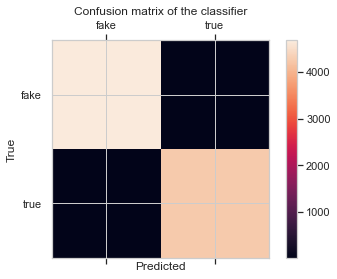

In [122]:
plot_confusion_matrix(cm_svc)

#### Cross validation metrics for the TF-IDF vectorizer

In [123]:
scores = cross_val_score(svc, tfidf_train, y_train, cv=5, scoring='accuracy')
print(scores)

[0.99512671 0.99470899 0.99610136 0.99582289 0.99331662]


#### Predict using K-Nearest Neighbors

ref: https://www.datacamp.com/community/tutorials/k-nearest-neighbor-classification-scikit-learn

After doing research I learned that there is no statistical method or way to find the most optimal number of K, but they are suggestions to finding the K of KNN. The below script executes a loop from 1 to 50. In each iteration the mean error for predicted values of test set is calculated and the result is appended to the error list.

ref: https://theprofessionalspoint.blogspot.com/2019/02/how-to-choose-optimal-value-of-k-in-knn.html
ref: https://medium.datadriveninvestor.com/k-nearest-neighbours-knn-a9f8ba09cb8b
ref: https://stackabuse.com/k-nearest-neighbors-algorithm-in-python-and-scikit-learn/

In [74]:
error_rate = []

# train_accuracy = np.empty(len(neighbors))
# test_accuracy = np.empty(len(neighbors))

for K in range(1,40):
    K = K+1

    knn_classifier = KNeighborsClassifier(n_neighbors=K)
    knn_classifier.fit(tfidf_train, y_train)
    test_pred = knn_classifier.predict(tfidf_test)
    
    error_rate.append(np.mean(test_pred != y_test))

After getting the mean error for the predicted values, i am going to plot the error to get an idea of what's the most optimal for K

Text(0, 0.5, 'Error Rate')

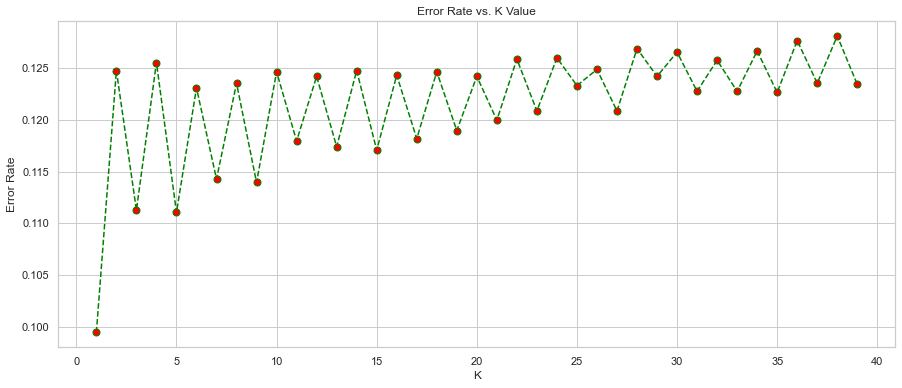

In [75]:
plt.figure(figsize=(15,6))
plt.plot(range(1,40), error_rate, color='green', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=7)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

It looks like the K with the lowest error rate is 1.

But before making any assumptions and unsupported choices I will do a grid search on KNN to get the best possible number for K.

#### KNN GridSearchCV

In [ ]:
knn_classifier = KNeighborsClassifier()

In [77]:
k_range = list(range(1,50))
weight_options = ["uniform", "distance"]
param_grid = dict(n_neighbors = k_range, weights = weight_options)

grid_knn = GridSearchCV(knn_classifier, param_grid, cv=10, scoring='accuracy')

In [78]:
grid_knn.fit(tfidf_train, y_train)

GridSearchCV(cv=10,
             estimator=KNeighborsClassifier(metric='euclidean', n_neighbors=1),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [79]:
print (grid_knn.best_score_)
print (grid_knn.best_params_)
print (grid_knn.best_estimator_)

0.9101921470342523
{'n_neighbors': 38, 'weights': 'distance'}
KNeighborsClassifier(metric='euclidean', n_neighbors=38, weights='distance')


To know what's the best possible K, I printed the best score, best parameters, and the best estimator that the GS returned. Above you can see that the best K is 38 and has an score of 91.01. That seems okay, so let's try it out with KNN and predict to get results.

#### KNN prediction using tf-idf vectorizer

In [108]:
knn_classifier = KNeighborsClassifier(n_neighbors=38, p=2, metric='euclidean', weights='distance')
knn_classifier.fit(tfidf_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=38, weights='distance')

In [117]:
# predict on the test data
y_pred_knn = knn_classifier.predict(tfidf_test)

#### Metrics for KNN prediction

Metrics for the KNN model

ref: https://medium.com/30-days-of-machine-learning/day-3-k-nearest-neighbors-and-bias-variance-tradeoff-75f84d515bdb

In [118]:
print("Accuracy in percentage:", metrics.accuracy_score(y_test, y_pred_knn)*100)

tn_knn, fp_knn, fn_knn, tp_knn = metrics.confusion_matrix(y_test, y_pred_knn, labels=['fake', 'true']).ravel()
print('True negative:',tn_knn , ' - ', 'False positive:', fp_knn, 
      ' - ', 'False negative:', fn_knn, ' - ', 'True positive:', tp_knn)

cm_knn = metrics.confusion_matrix(y_test, y_pred_knn, labels=['fake', 'true'])
print(cm_knn)

Accuracy in percentage: 91.1227444865226
True negative: 4115  -  False positive: 579  -  False negative: 218  -  True positive: 4066
[[4115  579]
 [ 218 4066]]


After trying K = 38, the accuracy returns an accuracy score of 91.12%. With 4066 true positives and 4115 true negatives, leaving room for 579 fps, and 218 fns.

Plot confusion matrix

<ipython-input-41-84b40dbd2607>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-41-84b40dbd2607>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


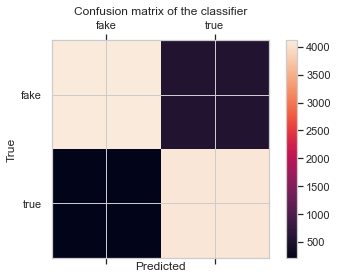

In [120]:
plot_confusion_matrix(cm_knn)

Print cross validation score

In [121]:
scores = cross_val_score(knn_classifier, tfidf_train, y_train, cv=5, scoring='accuracy')
print(scores)

[0.90629351 0.90281259 0.9085213  0.90239488 0.91088833]


#### Save KNN model

In [119]:
with open('knn_tfidf_pred', 'wb') as file:
    pickle.dump(knn_classifier, file)

#### Save model to file

I am using pickle to save the model.
For my CNN project I used HD5 to save the model because that was binary data, and HD5 performs better with binary data.

ref: https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/
ref: https://www.geeksforgeeks.org/ml-saving-a-deep-learning-model-in-keras/
ref: http://www.benfrederickson.com/dont-pickle-your-data/

In [272]:
import pickle

In [285]:
with open('text_classifier_all_algorithms_pickle', 'wb') as file:
    pickle.dump(nb_classifier, file)

#### Load model and run application to get prediction

In [286]:
# with open('nb_classifier_pickle', 'rb') as file:
#     model = pickle.load(file)

In [154]:
statement = 'Donald Trump wins the U.S. presidential election in 2016'

# statement = input("Enter news:")
# print("You entered: " + str(statement))

def fakenews(statement):
    load_model = pickle.load(open('knn_tfidf_pred', 'rb'))
    tfidf_pred = tfidf_vectorizer.transform([statement])
    prediction = load_model.predict(tfidf_pred)
    
    return (print("The statement is: ", prediction))

if __name__ == '__main__':
    fakenews(statement)

The statement is:  ['true']
